In [1]:
!apt update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar -xvf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,192 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,454 kB]
Get:13 https://r2u.stat.illinois

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/MyDrive/DL07_k299_LeThiThanhTruc/Cung_cap_HV'

/content/gdrive/MyDrive/DL07_k299_LeThiThanhTruc/Cung_cap_HV


In [4]:
import pandas as pd
import wordcloud as wc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:
df = pd.read_csv('data/processed_data.csv')
df = df[['noi_dung_binh_luan','thai_do']]
df.head()

,noi_dung_binh_luan,thai_do
0,sử_dụng dễ_dàng rất_thoải_mái thư_giãn,positive
1,sử_dụng dễ dãng rất_thoải_mái thư_giãn,positive
2,rất_thích hasaki_va sản_phẩm tẩy_trang,positive
3,sản_phẩm có khả_năng làm sạch tốt lớp trang_đi...,positive
4,sữa rửa mặt tốt sạch mụn mịn da_đáng mua,positive


In [7]:
df.fillna('trống', inplace=True)

In [8]:
thai_do_dict = {'positive':1, 'negative':0}
df['thai_do'] = df['thai_do'].map(thai_do_dict)
df.head()

,noi_dung_binh_luan,thai_do
0,sử_dụng dễ_dàng rất_thoải_mái thư_giãn,1
1,sử_dụng dễ dãng rất_thoải_mái thư_giãn,1
2,rất_thích hasaki_va sản_phẩm tẩy_trang,1
3,sản_phẩm có khả_năng làm sạch tốt lớp trang_đi...,1
4,sữa rửa mặt tốt sạch mụn mịn da_đáng mua,1


In [9]:
df['thai_do'].value_counts()

,count
thai_do,
1,18650
0,2024


In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['noi_dung_binh_luan'], df['thai_do'], test_size=0.2, random_state=42, stratify=df['thai_do'])

print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

Shape of X_train:  (16539,)
Shape of y_train:  (16539,)


In [11]:
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights:", class_weight_dict)

vectorizer = TfidfVectorizer(max_features=500)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

Class Weights: {0: 5.107782581840643, 1: 0.5542560321715818}


In [12]:
svm_model = LinearSVC(class_weight=class_weight_dict)
svm_model.fit(X_train_vectorized, y_train)

LinearSVC(class_weight={0: 5.107782581840643, 1: 0.5542560321715818})

In [13]:
y_pred = svm_model.predict(X_test_vectorized)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8957678355501814

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.89      0.62       405
           1       0.99      0.90      0.94      3730

    accuracy                           0.90      4135
   macro avg       0.73      0.89      0.78      4135
weighted avg       0.94      0.90      0.91      4135



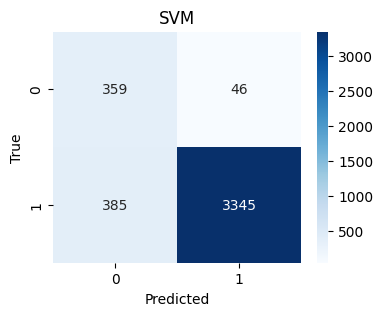

In [14]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title('SVM')
plt.show()

In [15]:
from xgboost import XGBClassifier

# Train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_vectorized, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:33:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [16]:
# Evaluate the model
y_pred = xgb_model.predict(X_test_vectorized)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9712212817412333

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.74      0.83       405
           1       0.97      1.00      0.98      3730

    accuracy                           0.97      4135
   macro avg       0.97      0.87      0.91      4135
weighted avg       0.97      0.97      0.97      4135



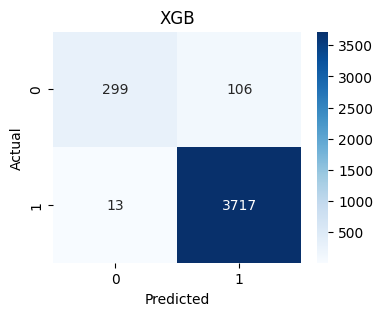

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGB")
plt.show()

In [18]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(class_weight='balanced', solver='liblinear')
log_reg_model.fit(X_train_vectorized, y_train)

LogisticRegression(class_weight='balanced', solver='liblinear')

In [19]:
y_pred = log_reg_model.predict(X_test_vectorized)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8887545344619106

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.88      0.61       405
           1       0.99      0.89      0.94      3730

    accuracy                           0.89      4135
   macro avg       0.72      0.88      0.77      4135
weighted avg       0.93      0.89      0.90      4135



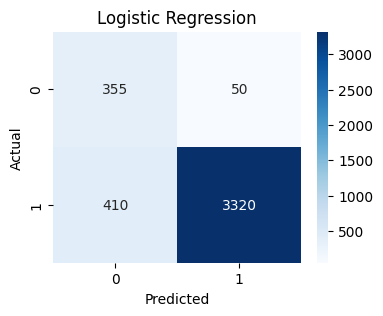

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression")
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       405
           1       0.99      1.00      0.99      3730

    accuracy                           0.98      4135
   macro avg       0.97      0.93      0.95      4135
weighted avg       0.98      0.98      0.98      4135



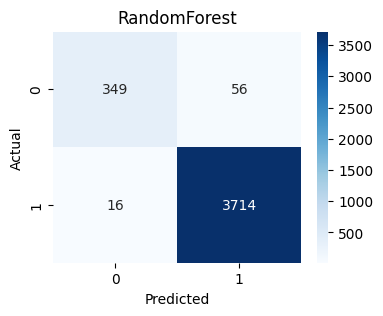

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Step 2: Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vectorized, y_train)

# Step 3: Make predictions on the validation set
y_pred = rf_model.predict(X_test_vectorized)

# Step 4: Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("RandomForest")
plt.show()

In [22]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9825876662636034

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.86      0.91       405
           1       0.99      1.00      0.99      3730

    accuracy                           0.98      4135
   macro avg       0.97      0.93      0.95      4135
weighted avg       0.98      0.98      0.98      4135



In [29]:
from sklearn. metrics import classification_report, roc_auc_score, roc_curve

In [31]:
score_train = rf_model.score(X_train_vectorized,y_train)
score_test = rf_model.score(X_test_vectorized,y_test)
acc = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

cr = classification_report(y_test, y_pred)

y_prob = rf_model.predict_proba(X_test_vectorized)
roc = roc_auc_score(y_test, y_prob[:, 1])

In [51]:
import pickle
import streamlit as st

In [26]:
pkl_filename = "model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf_model, file)

In [27]:
# luu model CountVectorizer (count)
pkl_vectorizer = "vectorizer_model.pkl"
with open(pkl_vectorizer, 'wb') as file:
    pickle.dump(vectorizer, file)

In [28]:
#6. Load models
# Đọc model
# import pickle
with open(pkl_filename, 'rb') as file:
    rf_model = pickle.load(file)
# doc model count len
with open(pkl_vectorizer, 'rb') as file:
    vectorizer_model = pickle.load(file)